# Arificial neural networks for age classification

In [ ]:
# import packages 
import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs
from keras import utils

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Data 
df = pd.read_csv("/Users/mauropazmino/Documents/Learning/Deep_learning_tensor/data/MIRS_temperature_vs_age_20241014.dat", sep="\t")


In [3]:
df.head()

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,...,420,418,416,414,412,410,408,406,404,402
0,AC,S,0,YY,SU,T1,C1,R1,190823,111223,...,0.2321,0.2309,0.2283,0.2274,0.2275,0.2286,0.2305,0.2316,0.2323,0.2336
1,AC,S,0,YY,SU,T1,C1,R1,190823,111223,...,0.2223,0.2198,0.2187,0.2192,0.2195,0.2192,0.2194,0.2211,0.2225,0.2222
2,AC,S,0,YY,SU,T1,C1,R1,190823,111223,...,0.2040,0.2028,0.2019,0.2022,0.2037,0.2048,0.2054,0.2056,0.2047,0.2036
3,AC,S,0,YY,SU,T1,C1,R1,190823,111223,...,0.2409,0.2389,0.2364,0.2353,0.2360,0.2368,0.2372,0.2380,0.2390,0.2398
4,AC,S,0,YY,SU,T1,C1,R1,190823,111223,...,0.2150,0.2155,0.2152,0.2150,0.2154,0.2154,0.2156,0.2165,0.2181,0.2191


In [3]:
df.rename(columns={'Cat3':'Age'}, inplace=True)

In [4]:
df['Age'].dtypes


dtype('int64')

In [5]:
df_gambiae = df[df['Cat1'] == 'AG']
df_gambiae = df_gambiae.copy()

In [6]:
age_groups  = df_gambiae["Age"]

In [7]:
conditions = [
(age_groups >= 0) & (age_groups <= 6),
(age_groups > 6) & (age_groups <= 16),
(age_groups > 16) & (age_groups <= 31)
]

choices  = [
      "0 - 6d",
      "8 - 16d",
      "18 - 31d"
]

In [8]:
df_gambiae["Age groups"] = np.select(conditions, choices, "ERROR")
df_gambiae["Age gorups"] = df_gambiae["Age groups"].astype('category')

In [ ]:
#| label: agegroups
df_gambiae['Age groups'].unique()

array(['0 - 6d', '8 - 16d', '18 - 31d'], dtype=object)

<Axes: xlabel='Age groups'>

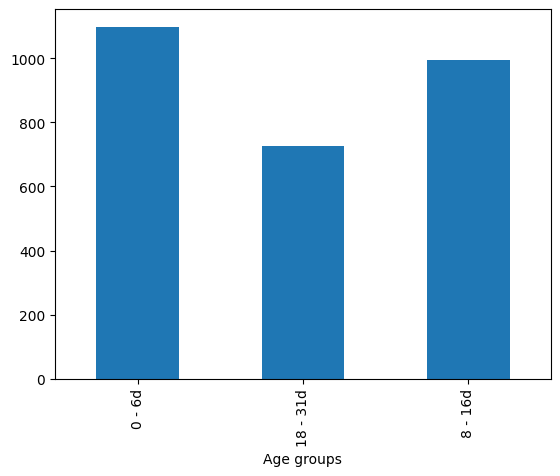

In [ ]:
#| label: balanced
df_gambiae.groupby('Age groups')['Cat1'].count().plot.bar()


In [11]:
X = np.asarray(df_gambiae.loc[:,"4000":'402'])
y = np.asarray(df_gambiae.loc[:, 'Age groups'])

In [12]:
print(X.shape)
print(y.shape)

(2820, 1800)
(2820,)


In [ ]:
#| label: encode
# Encode the labels from 0 to n-1 classes
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)
encoder.classes_

array(['0 - 6d', '18 - 31d', '8 - 16d'], dtype=object)

In [ ]:
#| label: hotencoding
# transform the encoded labels into a binary class matrix
yhot = utils.to_categorical(encoded_y)
print(yhot)
print(yhot.shape)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
(2820, 3)


In [35]:
# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, yhot, shuffle=True, test_size=0.2)

In [36]:
# Scaling train and test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split it further train set into train and validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.2)

In [37]:
# functions to eliminate part of the messages when training ANN
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots()
  ]

In [ ]:
#|label: modelage
input_shape = [1800,]
model = keras.Sequential()
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 500)            │       900,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 902,003 (3.44 MB)

 Trainable params: 902,003 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(x=X_train_2, y=y_train_2, epochs=500, batch_size=250, validation_data=[X_val, y_val],verbose=0,callbacks=get_callbacks('model_baseline'))


Epoch: 0, accuracy:0.4035,  loss:3.6213,  val_accuracy:0.4558,  val_loss:2.0265,  
....................................................................................................
Epoch: 100, accuracy:0.8941,  loss:0.2837,  val_accuracy:0.8208,  val_loss:0.4993,  
....................................................................................................
Epoch: 200, accuracy:0.9873,  loss:0.0769,  val_accuracy:0.8186,  val_loss:0.5021,  
....................................................................................................
Epoch: 300, accuracy:0.9989,  loss:0.0293,  val_accuracy:0.8584,  val_loss:0.5215,  
....................................................................................................
Epoch: 400, accuracy:0.9994,  loss:0.0120,  val_accuracy:0.8518,  val_loss:0.5361,  
....................................................................................................

(0.0, 1.5)

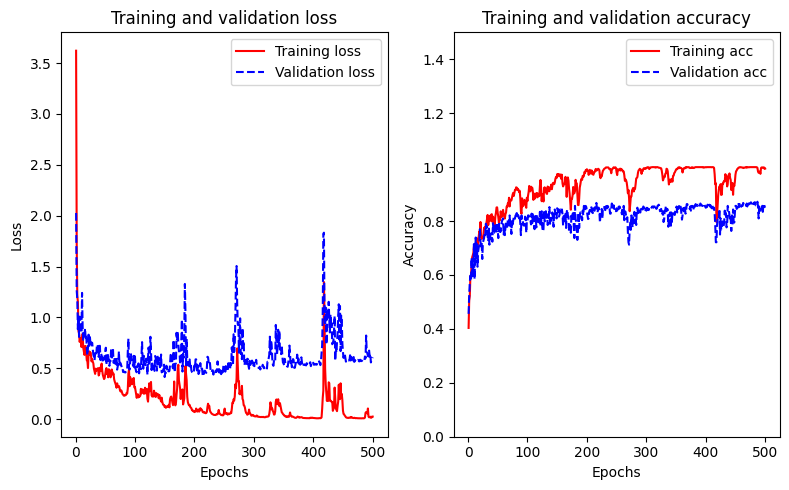

In [ ]:
#|label: lossmulti
# Check training and validation curves
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8,5), tight_layout=True)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax.plot(epochs, loss, 'r-', label='Training loss')
ax.plot(epochs, val_loss, 'b--', label='Validation loss')
ax.set_title('Training and validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
ax2.plot(epochs, acc, 'r-', label='Training acc')
ax2.plot(epochs, val_acc, 'b--', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

ax.legend()
ax2.legend()
ax2.set_ylim(0,1.5)

In [ ]:
#|label: eval
# model evaluation
model.evaluate(X_test, y_test)

# Make predictions
y_proba = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.6882
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
#|label: probasample
# the model gave us the proability of that samples to be 0, 1 or 2 category
print(y_proba[0])

[1.9061598e-07 6.7195423e-02 9.3280441e-01]


In [ ]:
#|label: argmax
# Select the index with the highest value
y_pred = np.argmax(y_proba, axis=1) 
y_pred

array([2, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 0, 0, 1, 1, 2, 2, 0,
       2, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 2, 2,
       2, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 1, 0, 2,
       2, 1, 1, 2, 0, 2, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 2, 1, 0, 0, 2,
       1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 2, 1,
       0, 1, 2, 1, 2, 0, 0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 2, 2, 0, 1, 1, 1,
       2, 0, 2, 1, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2,
       2, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 2,
       2, 0, 0, 0, 2, 2, 1, 1, 0, 0, 1, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0,
       0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 2, 0, 2, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 1, 2, 0, 2, 1, 0, 1, 0, 1, 1,
       2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 0,
       2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1,

In [ ]:
#|label: reverse
# reverse the encoding to obtaing the original classes
# one way of doing is using the argument classes from the encoder and pass the indexes of the highest values of the probabilities for each class. 
y_pred_oneform = encoder.classes_[np.argmax(y_proba,axis=1)]


# the second way is use the inverse transform function from the encoder to get the original classes
y_pred_secform = encoder.inverse_transform(y_pred) 

In [ ]:
#|label: same
# they are the same
print(y_pred_oneform[0])
print(y_pred_secform[0])

8 - 16d
8 - 16d


In [ ]:
# same treatment for y_test
y_new_test = np.argmax(y_test, axis=1)

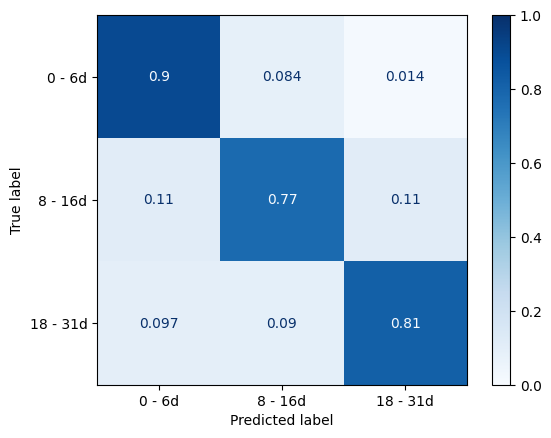

In [ ]:
#|label: cm
# Confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_pred=encoder.inverse_transform(y_pred),
    y_true=encoder.inverse_transform(y_new_test),
    normalize='true',
    cmap='Blues',
    im_kw={'vmin':0, 'vmax':1},
    labels=['0 - 6d', '8 - 16d', '18 - 31d'])